In [1]:
# !git clone https://github.com/Megvii-BaseDetection/YOLOX

In [2]:
import xml.etree.ElementTree as ET
import os
from tqdm import tqdm
import shutil
def modify_xml_jpg_file(data_dir, out_dir):
    jpg_path = list()
    xml_path = list()
    file_names = set()
    
    for root, dirs, files in os.walk(data_dir):
        for file in files:
            if file.endswith(".jpg"):
                if 'checkpoint' in file:
                    pass
                else:
                    file_path = os.path.join(root, file)
                    file_names.add(os.path.splitext(file_path.split(os.sep)[-1])[0])
                    jpg_path.append(file_path)
    
    for root, dirs, files in os.walk(data_dir):
        for file in files:
            if file.endswith(".xml"):
                if 'checkpoint' in file:
                    pass
                else:
                    file_path = os.path.join(root, file)
                    file_names.add(os.path.splitext(file_path.split(os.sep)[-1])[0])
                    xml_path.append(file_path)
    
    file_names = sorted(list(file_names))
    name_map = dict((n, i) for i, n in enumerate(file_names))
    
    for xml_file in tqdm(xml_path):
        xmlTree = ET.parse(xml_file)
        xml_name = os.path.splitext(xml_file.split(os.sep)[-1])[0]
        int_name = name_map[xml_name]
        rootElement = xmlTree.getroot()
        rootElement.findall("path")[0].text = f'{int_name}.jpg'
        rootElement.findall("filename")[0].text = f'{int_name}.jpg'

        sub_path = os.path.join(*xml_file.split(os.sep)[1:-1])
        write_dir = os.path.join(out_dir, sub_path)
        if os.path.exists(write_dir):
            pass
        else:
            os.makedirs(write_dir)

        write_path = os.path.join(write_dir, str(int_name)+'.xml')
        xmlTree.write(write_path, encoding='UTF-8', xml_declaration=True)
            
    for jpg_file in tqdm(jpg_path):
        jpg_name = os.path.splitext(jpg_file.split(os.sep)[-1])[0]
        int_name = name_map[jpg_name]

        sub_path = os.path.join(*jpg_file.split(os.sep)[1:-1])
        write_dir = os.path.join(out_dir, sub_path)
        if os.path.exists(write_dir):
            pass
        else:
            os.makedirs(write_dir)
        write_path = os.path.join(write_dir, str(int_name)+'.jpg')
        shutil.copy2(jpg_file, write_path)         


In [3]:
modify_xml_jpg_file('linmao-new', out_dir='linmao-new_processed')


100%|██████████| 8407/8407 [04:59<00:00, 28.07it/s] 


# (Train/Validation split data)

In [4]:
import os

dataset_directory = 'linmao-new_processed'

train_directory = './train'
validation_directory = './validation'

os.makedirs(train_directory, exist_ok=True)
os.makedirs(validation_directory, exist_ok=True)

In [5]:
import glob
import shutil
import random

train_ratio = 0.8

annotation_list = sorted(glob.glob(dataset_directory +'/Annotations'+ '/*.xml'))
image_list = sorted(glob.glob(dataset_directory +'/JPEGImages' + '/*.jpg'))

file_num = len(annotation_list)

index_list = list(range(file_num - 1))
random.shuffle(index_list)

for count, index in enumerate(tqdm(index_list)):
    if count < int(file_num * train_ratio):
        shutil.copy2(annotation_list[index], train_directory)
        shutil.copy2(image_list[index], train_directory)
    else:
        shutil.copy2(annotation_list[index], validation_directory)
        shutil.copy2(image_list[index], validation_directory)

100%|██████████| 8406/8406 [03:14<00:00, 43.23it/s] 


# (Convert Pascal VOC format to MS COCO format)

In [6]:
# !git clone https://github.com/Kazuhito00/voc2coco.git

In [7]:
# put this into voc2coco.py

label_map = {'nl_0438': 0,
             'nl_0431': 1,
             'nl_0239': 2,
             'nl_0238': 3,
             'nl_0271': 4,
             'nl_0280': 5,
             'nl_0433': 6,
             'nl_0224': 7,
             'nl_0098': 8}

In [8]:
!python voc2coco.py train train/train_annotations.json
!python voc2coco.py validation validation/validation_annotations.json

Number of xml files: 6725
Success: train/train_annotations.json
Number of xml files: 1681
Success: validation/validation_annotations.json


# (Training data directory preparation)

In [9]:
!mkdir dataset
!mkdir dataset/images
!mkdir dataset/images/train2017
!mkdir dataset/images/val2017
!mkdir dataset/images/annotations

!cp -rf train/*.jpg dataset/images/train2017
!cp -rf validation/*.jpg dataset/images/val2017
!cp -rf train/train_annotations.json dataset/images/annotations
!cp -rf validation/validation_annotations.json dataset/images/annotations

# Train

In [10]:
!rm -rf YOLOX/dataset

In [11]:
!mv dataset YOLOX/dataset

In [49]:
%cd YOLOX/
# !wget https://github.com/Megvii-BaseDetection/storage/releases/download/0.0.1/yolox_nano.pthz

/home/jupyter/YOLOX_Run/YOLOX


In [13]:
# Copy train.py to root, since it needs to import from yolox
# !cp tools/train.py ./

In [15]:
# Modify nano.py for epochs and other info

In [51]:
!python train.py -f nano.py -d 1 -b 16 --fp16 -o -c yolox_nano.pth

2022-01-24 02:03:03 | INFO     | yolox.core.trainer:126 - args: Namespace(batch_size=16, cache=False, ckpt='yolox_nano.pth', devices=1, dist_backend='nccl', dist_url=None, exp_file='nano.py', experiment_name='nano', fp16=True, machine_rank=0, name=None, num_machines=1, occupy=True, opts=[], resume=False, start_epoch=None)
2022-01-24 02:03:03 | INFO     | yolox.core.trainer:127 - exp value:
╒══════════════════╤═══════════════════════════════╕
│ keys             │ values                        │
╞══════════════════╪═══════════════════════════════╡
│ seed             │ None                          │
├──────────────────┼───────────────────────────────┤
│ output_dir       │ './YOLOX_outputs'             │
├──────────────────┼───────────────────────────────┤
│ print_interval   │ 10                            │
├──────────────────┼───────────────────────────────┤
│ eval_interval    │ 1                             │
├──────────────────┼───────────────────────────────┤
│ num_classes      │ 9  

# (Inference test)
### !cp tools/demo.py ./

## modify demo.py get class names
## names can be set up at YOLOX/yolox/data/datasets/limao_classes.py

In [54]:
# TEST_IMAGE_PATH = "dataset/images/val2017/"
TEST_IMAGE_PATH = "../linmao-test/JPEGImages"

MODEL_PATH = "YOLOX_outputs/nano/best_ckpt.pth"

!python demo-modified.py image \
    -f nano.py \
    -c {MODEL_PATH} \
    --path {TEST_IMAGE_PATH} \
    --conf 0.25 \
    --nms 0.45 \
    --tsize 640 \
    --save_result \
    --device gpu

2022-01-24 03:03:50.484 | INFO     | __main__:main:285 - Args: Namespace(camid=0, ckpt='YOLOX_outputs/nano/best_ckpt.pth', conf=0.25, demo='image', device='gpu', exp_file='nano.py', experiment_name='nano', fp16=False, fuse=False, legacy=False, name=None, nms=0.45, path='../linmao-test/JPEGImages', save_result=True, trt=False, tsize=640)
2022-01-24 03:03:50.654 | INFO     | __main__:main:295 - Model Summary: Params: 0.90M, Gflops: 2.48
2022-01-24 03:03:54.783 | INFO     | __main__:main:308 - loading checkpoint
2022-01-24 03:03:54.868 | INFO     | __main__:main:312 - loaded checkpoint done.
2022-01-24 03:03:55.237 | INFO     | __main__:inference:165 - Infer time: 0.3172s
2022-01-24 03:03:55.239 | INFO     | __main__:image_demo:232 - Saving detection result in ./YOLOX_outputs/nano/vis_res/2022_01_24_03_03_54/nl_0098_0001.jpg
2022-01-24 03:03:55.342 | INFO     | __main__:inference:165 - Infer time: 0.0164s
2022-01-24 03:03:55.344 | INFO     | __main__:image_demo:232 - Saving detection resu

In [55]:
%cd ..

/home/jupyter/YOLOX_Run


In [56]:
from object_detect.convert_xml_label_to_txt import convert
import os
import shutil

In [57]:
xml_dir = 'linmao-test'
out_dir = f'{xml_dir}_txt'
label_map = {'nl_0438': 0,
             'nl_0431': 1,
             'nl_0239': 2,
             'nl_0238': 3,
             'nl_0271': 4,
             'nl_0280': 5,
             'nl_0433': 6,
             'nl_0224': 7,
             'nl_0098': 8}

In [48]:
label_dict = convert(xml_dir, out_dir, label_map, True)


# Metrics

In [58]:
from object_detect.metrics import label_metrics
pred_txt_dir = 'YOLOX/YOLOX_outputs/nano/vis_res/2022_01_24_03_03_54/labels' # runs/detect/combined_yolo_cls/labels
truth_txt_dir = 'linmao-test_txt/Annotations'
lm = label_metrics(pred_txt_dir, truth_txt_dir)
summary_df = lm.get_metrics(iou_thresholds=[0.5], interpolate_pr=True)

  0%|          | 0/9 [00:00<?, ?it/s]

processing IoU@0.5


100%|██████████| 9/9 [00:25<00:00,  2.78s/it]


In [59]:
summary_df.label = summary_df.label.replace(label_map)
summary_df

,label,P@0.5,R@0.5,F1@0.5,AP@0.5,P@All,R@All,F1@All,AP@All
0,0,0.853895,0.838047,0.845971,0.808020,0.853895,0.838047,0.845971,0.808020
1,1,0.169659,0.843077,0.506368,0.409055,0.169659,0.843077,0.506368,0.409055
2,2,0.747695,0.534772,0.641234,0.521095,0.747695,0.534772,0.641234,0.521095
3,3,0.641316,0.392668,0.516992,0.329157,0.641316,0.392668,0.516992,0.329157
4,4,0.058824,0.015625,0.037224,0.001562,0.058824,0.015625,0.037224,0.001562
5,5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,6,0.086420,0.241379,0.163900,0.073606,0.086420,0.241379,0.163900,0.073606
7,7,0.568151,0.452688,0.510420,0.379099,0.568151,0.452688,0.510420,0.379099
8,8,0.516981,0.218501,0.367741,0.169682,0.516981,0.218501,0.367741,0.169682
9,All,0.404771,0.392973,0.398872,0.299031,0.404771,0.392973,0.398872,0.299031


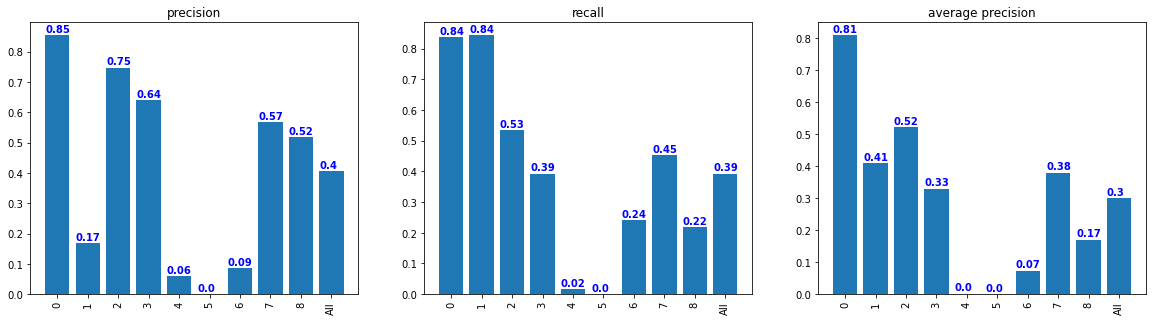

In [60]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 5))
plt.subplot(131)
x = [str(i) for i in summary_df['label']]
precisions = summary_df['P@0.5'].tolist()
plt.title('precision')
plt.bar(x, precisions)
plt.xticks(rotation=90)
for i, v in enumerate(x):
    plt.text(i-0.4, precisions[i]+0.01, str(round(precisions[i], 2)), color='blue', fontweight='bold')

plt.subplot(132)
recalls = summary_df['R@0.5'].tolist()
plt.title('recall')
plt.bar(x, recalls)
plt.xticks(rotation=90)
for i, v in enumerate(x):
    plt.text(i-0.4, recalls[i]+0.01, str(round(recalls[i], 2)), color='blue', fontweight='bold')

plt.subplot(133)
aps = summary_df['AP@0.5'].tolist()
plt.title('average precision')
plt.bar(x, aps)
plt.xticks(rotation=90)
for i, v in enumerate(x):
    plt.text(i-0.4, aps[i]+0.01, str(round(aps[i], 2)), color='blue', fontweight='bold')

In [61]:
label_confuse = lm.find_confuse_labels(iou_threshold=0.5, box_format='midpoint')


100%|██████████| 1047/1047 [01:05<00:00, 15.94it/s]


In [62]:
label_confuse['precision']


{1: [(3, 588),
  (2, 314),
  (1, 274),
  (0, 163),
  ('background', 147),
  (8, 48),
  (6, 43),
  (4, 16),
  (5, 12),
  (7, 10)],
 6: [(3, 134), ('background', 14), (6, 14)],
 0: [(0, 3797), ('background', 522), (2, 95), (1, 16), (3, 12)],
 7: [(7, 426), ('background', 167), (3, 90), (8, 45), (4, 8), (2, 5)],
 3: [(3, 1190),
  ('background', 446),
  (2, 124),
  (0, 38),
  (7, 31),
  (8, 18),
  (1, 3),
  (5, 3),
  (4, 1)],
 8: [(8, 137), ('background', 67), (7, 52), (3, 6), (4, 3)],
 2: [(2, 912), ('background', 179), (3, 85), (0, 7), (5, 5), (4, 4), (7, 1)],
 4: [(3, 5), (8, 5), (7, 5), (4, 1), ('background', 1)]}

In [63]:
label_confuse['recall']


{2: [(2, 893), (1, 314), ('background', 238), (3, 123), (0, 95), (7, 5)],
 3: [(3, 1190),
  ('background', 915),
  (1, 592),
  (6, 134),
  (7, 89),
  (2, 85),
  (0, 12),
  (8, 6),
  (4, 5)],
 0: [(0, 3800), ('background', 517), (1, 164), (3, 38), (2, 7)],
 4: [('background', 32), (1, 16), (7, 8), (2, 3), (8, 3), (4, 1), (3, 1)],
 8: [('background', 374), (8, 137), (1, 48), (7, 45), (3, 18), (4, 5)],
 7: [(7, 420), ('background', 412), (8, 51), (3, 31), (1, 10), (4, 5), (2, 1)],
 6: [(1, 43), (6, 14), ('background', 1)],
 1: [(1, 274), ('background', 31), (0, 17), (3, 3)],
 5: [('background', 12), (1, 12), (2, 5), (3, 3)]}

In [ ]:
# from PIL import Image

# OUTPUT_IMAGE_PATH = "/content/YOLOX/YOLOX_outputs/nano/vis_res/2021_09_29_17_46_56/000050.jpg" 
# Image.open(OUTPUT_IMAGE_PATH)

# ONNX出力(Export ONNX Model)

In [ ]:
!python tools/export_onnx.py \
    --output-name yolox_nano.onnx \
    -n yolox-nano \
    -f nano.py \
    -c {MODEL_PATH}

In [ ]:
!python demo/ONNXRuntime/onnx_inference.py \
    -m yolox_nano.onnx \
    -i {TEST_IMAGE_PATH} \
    -o ./ \
    -s 0.3 \
    --input_shape 416,416

In [ ]:
from PIL import Image

OUTPUT_IMAGE_PATH = "000050.jpg" 
Image.open(OUTPUT_IMAGE_PATH)

# ONNX -> TensorFlow 変換

In [ ]:
!pip install onnx-tf

In [ ]:
!onnx-tf convert \
    -i yolox_nano.onnx \
    -o yolox_nano_pb

# TensorFlow -> TensorFlow-Lite 変換

In [ ]:
!pip install tf-nightly

In [ ]:
import tensorflow as tf

In [ ]:
%cd /content/YOLOX

In [ ]:
# ダイナミックレンジ量子化
converter = tf.lite.TFLiteConverter.from_saved_model('yolox_nano_pb')
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open('yolox_nano_dynamic_range_quantize.tflite', 'wb').write(tflite_quantized_model)

In [ ]:
# 半精度浮動小数点数の量子化
converter = tf.lite.TFLiteConverter.from_saved_model('yolox_nano_pb')
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
tflite_quantized_model = converter.convert()

open('yolox_nano_float16_quantize.tflite', 'wb').write(tflite_quantized_model)

In [ ]:
# 完全整数量子化
import glob
import numpy as np
from PIL import Image

test_image_pathlist = glob.glob('/content/YOLOX-Colaboratory-Training-Sample/01.image/*.jpg')
test_image_pathlist = test_image_pathlist[:100]
print(len(test_image_pathlist))

def representative_dataset():
    for test_image_path in test_image_pathlist:
        image = np.array(Image.open(test_image_path))
        image = image.astype('float32')
        image = tf.image.resize(image, (416, 416))
        image = image - 127.5
        image = image * 0.007843
        image = tf.transpose(image, perm=[2, 0, 1])
        image = tf.reshape(image, [1, 3, 416, 416])
        yield [image]

converter = tf.lite.TFLiteConverter.from_saved_model('yolox_nano_pb')
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
tflite_quantized_model = converter.convert()

open('yolox_nano_int8_quantize.tflite', 'wb').write(tflite_quantized_model)

In [ ]:
# 完全整数量子化(入力含む)
import glob
import numpy as np
from PIL import Image

test_image_pathlist = glob.glob('/content/YOLOX-Colaboratory-Training-Sample/01.image/*.jpg')
test_image_pathlist = test_image_pathlist[:100]
print(len(test_image_pathlist))

def representative_dataset():
    for test_image_path in test_image_pathlist:
        image = np.array(Image.open(test_image_path))
        image = image.astype('float32')
        image = tf.image.resize(image, (416, 416))
        image = image - 127.5
        image = image * 0.007843
        image = tf.transpose(image, perm=[2, 0, 1])
        image = tf.reshape(image, [1, 3, 416, 416])
        yield [image]

converter = tf.lite.TFLiteConverter.from_saved_model('yolox_nano_pb')
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8  # or tf.uint8
converter.inference_output_type = tf.int8  # or tf.uint8
tflite_quantized_model = converter.convert()

open('yolox_nano_only_int8_quantize.tflite', 'wb').write(tflite_quantized_model)